### 2023 MLB Position Player Arbitration Model

This workbook uses linear regression to predict arbitration salaries for eligible players in the 2022-2023 offseason. This mosel uses player statistic and salary data from the 2018, 2019, 2021, and 2022 seasons.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix,plot_confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary, gainsChart, liftChart
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV



In [2]:
# Reading in stats and salary dataframe
train_df = pd.read_csv('position_players_arb_stats.csv')

In [3]:
# Drop Nulls
train_df = train_df.dropna()

In [4]:
# Make integer
train_df['previous_season_salary'] = train_df['previous_season_salary'].astype(int)

In [5]:
# Replacing positions
train_df = train_df.replace('c','batter')
train_df = train_df.replace('1b','batter')
train_df = train_df.replace('2b','batter')
train_df = train_df.replace('3b','batter')
train_df = train_df.replace('ss','batter')
train_df = train_df.replace('rf','batter')
train_df = train_df.replace('cf','batter')
train_df = train_df.replace('lf','batter')
train_df = train_df.replace('dh','batter')
train_df = train_df.replace('of','batter')
train_df = train_df.replace('inf','batter')

<ipython-input-6-85911f6f1fd6>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)


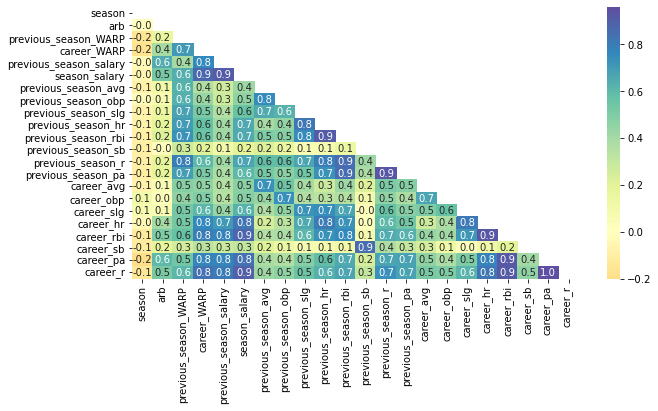

In [6]:
# Creating coorelation matrix

corr_df = train_df.corr()
# Include information about values
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask = mask_ut, annot=True, fmt=".1f", cmap="Spectral", center=0, ax=ax)

plt.show()

In [7]:
#dummies_df = pd.get_dummies(train_df, columns = ['season'],prefix_sep='_', drop_first=False)
#dummies_df.columns

In [8]:
# Columns
train_df.columns

Index(['player_name', 'season', 'Club', 'position', 'arb',
       'previous_season_WARP', 'career_WARP', 'previous_season_salary',
       'season_salary', 'previous_season_avg', 'previous_season_obp',
       'previous_season_slg', 'previous_season_hr', 'previous_season_rbi',
       'previous_season_sb', 'previous_season_r', 'previous_season_pa',
       'career_avg', 'career_obp', 'career_slg', 'career_hr', 'career_rbi',
       'career_sb', 'career_pa', 'career_r'],
      dtype='object')

In [9]:
predictors = ['arb', 'previous_season_WARP',
       'career_WARP', 'previous_season_salary',
       'previous_season_avg', 'previous_season_obp', 'previous_season_slg',
       'previous_season_hr', 'previous_season_rbi', 'previous_season_sb',
       'career_avg', 'career_obp', 'career_slg', 'career_hr', 'career_rbi',
       'career_sb','previous_season_r', 'previous_season_pa', 'career_pa', 'career_r']
outcome = ['season_salary']

# creating predictors and outcome to build predictive model

In [10]:
X = train_df[predictors]
y = train_df[outcome]

In [11]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, train_size=0.7, random_state = 1)

In [12]:
model = LinearRegression()
model.fit(train_X, train_y)
train_pred_logistic = model.predict(train_X)

In [13]:
train_results_logistic = pd.DataFrame(train_pred_logistic, columns = ['prediction'])

In [14]:
# Trained data real salary vs predicted
train_salaries_logistic = train_df[['player_name', 'Club', 'season_salary']]
train_salaries_logistic = train_salaries_logistic.join(train_results_logistic).round(-5).dropna().sample(10)
train_salaries_logistic

,player_name,Club,season_salary,prediction
105,"Culberson, Charlie",ATL,1400000,9400000.0
56,"Romine, Austin",NYA,1100000,3000000.0
98,"Conforto, Michael",NYN,4000000,4800000.0
107,"Shaw, Travis",MIL,4700000,9400000.0
9,"Pederson, Joc",LAN,2600000,8600000.0
214,"Schwarber, Kyle",CHN,7000000,2400000.0
22,"Bour, Justin",MIA,3400000,900000.0
81,"Peraza, Jose",CIN,2800000,9700000.0
110,"Duvall, Adam",ATL,2900000,2900000.0
240,"Leon, Sandy",CLE,2000000,1000000.0


In [15]:
# Trained data summary
regressionSummary(train_salaries_logistic.season_salary, train_salaries_logistic.prediction)


Regression statistics

                      Mean Error (ME) : -2020000.0000
       Root Mean Squared Error (RMSE) : 4498444.1755
            Mean Absolute Error (MAE) : 3640000.0000
          Mean Percentage Error (MPE) : -115.2110
Mean Absolute Percentage Error (MAPE) : 153.0597


In [16]:
# Run model for validation data
valid_pred_logistic = model.predict(train_X)

In [17]:
# Run lasso on model and print summary for validation
lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)
print(lasso_cv.coef_)


Regression statistics

                      Mean Error (ME) : 23964.6186
       Root Mean Squared Error (RMSE) : 989365.4017
            Mean Absolute Error (MAE) : 658618.7024
          Mean Percentage Error (MPE) : 1.0054
Mean Absolute Percentage Error (MAPE) : 17.9534
Lasso-CV chosen regularization:  602.126881306143
[-7.28102278e+04  6.02085750e+04  1.03251402e+05  8.61969902e-01
  5.16263369e+06  0.00000000e+00 -1.58089360e+06  5.17456523e+04
  1.17482996e+04  8.44636673e+03 -5.22529839e+05  3.23700902e+06
 -0.00000000e+00  1.78795258e+03 -0.00000000e+00  0.00000000e+00
  5.25809024e+03  0.00000000e+00 -6.76960346e+02  8.44824531e+03]


C:\Users\19083\anaconda3\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [18]:
y_pred_valid = lasso_cv.predict(valid_X)

In [19]:
# Real salary vs predicted salary from lasso model with validation data
valid_results = pd.DataFrame({
    'Salary': valid_y.season_salary, 
    'predicted': y_pred_valid})
valid_results.round().sort_values(["predicted"], ascending=True)

,Salary,predicted
186,800000,92664.0
95,850000,110161.0
172,710000,243491.0
173,725000,446809.0
0,870000,511417.0
...,...,...
70,16000000,16620889.0
161,18800000,17369535.0
132,20000000,18042870.0
244,21000000,18472566.0


In [20]:
valid_results_with_name = valid_results.join(train_df.player_name)

In [21]:
valid_results_new = valid_results_with_name.join(train_df.season)

# If condition on column values using Lambda function
# if model gave a predicted salary under 800k, replace with 800k.
valid_results_new['predicted'] = valid_results_new['predicted'].apply(lambda  x : 800000  if x < 800000 else x)

In [22]:
# New validation data results
valid_results_new['residual'] = valid_results_new['Salary'] - valid_results_new['predicted']
valid_results_new = valid_results_new.round(-5).sort_values(["predicted"], ascending=True)
valid_results_new

,Salary,predicted,player_name,season,residual
186,800000,800000.0,"Stassi, Max",0,0.0
256,1200000,800000.0,"Senzel, Nick",0,400000.0
95,800000,800000.0,"Cuthbert, Cheslor",0,0.0
85,1000000,800000.0,"Wolters, Tony",0,100000.0
0,900000,800000.0,"Rua, Ryan",0,100000.0
...,...,...,...,...,...
70,16000000,16600000.0,"Machado, Manny",0,-600000.0
161,18800000,17400000.0,"Rendon, Anthony",0,1400000.0
132,20000000,18000000.0,"Betts, Mookie",0,2000000.0
244,21000000,18500000.0,"Springer, George",0,2500000.0


In [23]:
valid_predicted = valid_results_new.predicted
valid_salary = valid_results_new.Salary

In [24]:
# New validation results summary
regressionSummary(valid_results_new.Salary, valid_results_new.predicted)


Regression statistics

                      Mean Error (ME) : -6603.7736
       Root Mean Squared Error (RMSE) : 982920.1776
            Mean Absolute Error (MAE) : 633018.8679
          Mean Percentage Error (MPE) : -2.8666
Mean Absolute Percentage Error (MAPE) : 14.9518


In [25]:
# Error calculation
valid_results_new['error'] = valid_results_new['residual'].abs()
valid_results_new.sort_values(["predicted"], ascending=True)

,Salary,predicted,player_name,season,residual,error
186,800000,800000.0,"Stassi, Max",0,0.0,0.0
256,1200000,800000.0,"Senzel, Nick",0,400000.0,400000.0
95,800000,800000.0,"Cuthbert, Cheslor",0,0.0,0.0
85,1000000,800000.0,"Wolters, Tony",0,100000.0,100000.0
0,900000,800000.0,"Rua, Ryan",0,100000.0,100000.0
...,...,...,...,...,...,...
70,16000000,16600000.0,"Machado, Manny",0,-600000.0,600000.0
161,18800000,17400000.0,"Rendon, Anthony",0,1400000.0,1400000.0
132,20000000,18000000.0,"Betts, Mookie",0,2000000.0,2000000.0
244,21000000,18500000.0,"Springer, George",0,2500000.0,2500000.0


In [26]:
# How many of the 106 in validation data missed by more than $300k? 
len(valid_results_new[valid_results_new['error']>300000])

54

In [27]:
# Reading in test dataframe

test_df = pd.read_csv('2023_arb_position.csv')
test_df = test_df.dropna()

# Dropping nulls

test_df['previous_season_salary'] = test_df['previous_season_salary'].astype(int)
# Converting to integer

In [28]:
test_df = test_df.replace('c','batter')
test_df = test_df.replace('1b','batter')
test_df = test_df.replace('2b','batter')
test_df = test_df.replace('3b','batter')
test_df = test_df.replace('ss','batter')
test_df = test_df.replace('rf','batter')
test_df = test_df.replace('cf','batter')
test_df = test_df.replace('lf','batter')
test_df = test_df.replace('of','batter')
test_df = test_df.replace('dh','batter')
test_df = test_df.replace('inf','batter')

In [29]:
X_test = test_df[predictors]

In [30]:
test_df['arb'] = test_df['arb'].astype(float)
# Converting to integer

In [31]:
y_pred_test = lasso_cv.predict(X_test)
# running model

In [32]:
test_results = pd.DataFrame({
    'predicted': y_pred_test})

test_results['predicted'] = test_results['predicted'].astype(int)
# if model gave a predicted salary under 800k, replace with 800k.
test_results['predicted'] = test_results['predicted'].apply(lambda  x : 800000  if x < 800000 else x)

# creating dataframe

test_results_with_name = test_results.join(test_df.player_name)
test_results_new = test_results_with_name.join(test_df.Club)
test_results_new = test_results_new.round(-5).sort_values(["predicted"], ascending=False)
test_results_new.sort_values(["predicted"], ascending=True)

,predicted,player_name,Club
111,800000,"Maile, Luke",CLE
17,800000,"Ríos, Edwin",LAN
18,800000,"Chang, Yu",BOS
23,800000,"Knizner, Andrew",SLN
38,800000,"Torrens, Luis",SEA
...,...,...,...
55,13100000,"Alonso, Pete",NYN
107,14000000,"Hernández, Teoscar",SEA
101,15700000,"Devers, Rafael",BOS
112,19500000,"Bellinger, Cody",LAN


In [33]:
club_2022_eda = test_results_new.groupby(['Club']).sum().round(0).sort_values(["predicted"], ascending=False)
club_2022_eda.head(10)

# top 10 teams in total projected Arbitration salaries

,predicted
Club,
TOR,36200000
SDN,33200000
NYN,27900000
BOS,25700000
MIA,25400000
LAN,25200000
ANA,25100000
MIL,24800000
SEA,22600000


In [34]:
team_salaries = test_results_new.loc[test_results_new['Club'] == 'NYA']
team_salaries = team_salaries.join(test_df.arb)
team_salaries = team_salaries.join(test_df.previous_season_WARP)
team_salaries = team_salaries.join(test_df.career_WARP)
team_salaries.sort_values(["predicted"], ascending=False).round(1)

# Showing Yankees arbitration breakdown and comparing to performance (WARP)

,predicted,player_name,Club,arb,previous_season_WARP,career_WARP
88,9700000,"Torres, Gleyber",NYA,3.0,2.9,11.7
90,6100000,"Kiner-Falefa, Isiah",NYA,3.0,1.3,5.9
31,2300000,"Trevino, Jose",NYA,1.0,3.6,6.7
59,1700000,"Higashioka, Kyle",NYA,2.0,1.8,4.6


In [35]:
mlbtr_df = pd.read_csv('2023_mlbtr.csv')
mlbtr_df.sort_values(["MLBTR"], ascending=False)

,MLBTR,player_name,Club
82,21500000,"Soto, Juan",SDN
49,18100000,"Bellinger, Cody",LAN
22,16900000,"Devers, Rafael",BOS
69,15900000,"Alonso, Pete",NYN
107,14800000,"Guerrero, Vladimir Jr.",TOR
...,...,...,...
94,1000000,"Knizner, Andrew",SLN
76,1000000,"Sosa, Edmundo",PHI
23,1000000,"Mendick, Danny",CHA
18,900000,"Chang, Yu",BOS


In [36]:
# My model salary breakdown by team

team_salaries_blutfield = test_results_new.loc[test_results_new['Club'] == 'SDN']
team_salaries_blutfield

,predicted,player_name,Club
81,21500000,"Soto, Juan",SDN
14,4000000,"Cronenworth, Jake",SDN
103,3100000,"Alfaro, Jorge",SDN
30,2800000,"Grisham, Trent",SDN
39,1800000,"Nola, Austin",SDN


In [37]:
# MLBTR salary breakdown by team

team_salaries_mlbtr = mlbtr_df.loc[mlbtr_df['Club'] == 'SDN']
team_salaries_mlbtr.sort_values(["MLBTR"], ascending=False)

,MLBTR,player_name,Club
82,21500000,"Soto, Juan",SDN
79,4400000,"Cronenworth, Jake",SDN
83,3600000,"Alfaro, Jorge",SDN
80,2600000,"Grisham, Trent",SDN
81,2200000,"Nola, Austin",SDN
